# D.1 - Characterization  of the Network

The main purpose of this explainer notebook is "Characterization", focusing both on the network in a general sense, discussion of goals as solitary nodes and interaction with users and their lists.

This explainer notebook has the following sections:

1. Downloading Network + Attribute Investigation
2. Degree Distribution - Density, Sparseness and Power-Law Investigation
3. Small World Attributes - Average Clustering and Path Length
4. Goal Investigation - Degree Values and Centrality Measures
5. User Interaction with Goals - List Appearance and Completedness
6. DataFrame of all Attributes

In [1]:
# importing all relevant packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests as rq
import pickle
import powerlaw

## 1. Downloading Network + Attribute Investigation 

First, we are going to import the network from our github, and then get an overview of all the attributes that we are working with. For this explainer notebook, we will be using the attributes "title", "wants_to_do", "have_done", "included_by_our_users". Mainly, we will be creating our own attributes, and will get a full overview of all the attributes at the end of our notebook.

In [2]:
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = rq.get(url)
G = pickle.loads(response.content)

print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network loaded: 2890 nodes, 219130 edges


## 2. Degree Distribution - Density, Sparseness and Power-Law Investigation

This section discusses the degree distribution, observing both weighted and unweighted degrees. We then proceed to investigate the spareness in relation to density and then more in depth with an investigation to whether the network has any power-law attributes.

### Weighted and Unweighted Degree and Density

Here, we investigate the different types of degree measures, including average degree, average weighted degree and density. The main focus here is to gain insight into whether the network itself is sparse, and what is the proportion of edges in comparison to total number of edges.

In [3]:
#degree
degrees = dict(G.degree())

#weighted degree
weighted_degree = dict(G.degree(weight="weight"))

#average neighbour degree
avg_neighbour_degree = nx.average_neighbor_degree(G)

#average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
avg_weighted_degree = sum(dict(G.degree(weight="weight")).values()) / G.number_of_nodes()

#density of the network
density = nx.density(G)

#adding degree as an attribute to the network
nx.set_node_attributes(G, degrees, "degree")

#adding weighted degree as an attribute to the network
nx.set_node_attributes(G, weighted_degree, "weighted degree")

#printing results
print(f"The average degree of the DayZero network is {round(avg_degree, 3)}.")
print(f"The average weighted degree of the DayZero network is {round(avg_weighted_degree, 3)}.")
print(f"The density of the network is {round(density, 3)}.")


The average degree of the DayZero network is 151.647.
The average weighted degree of the DayZero network is 302.473.
The density of the network is 0.052.


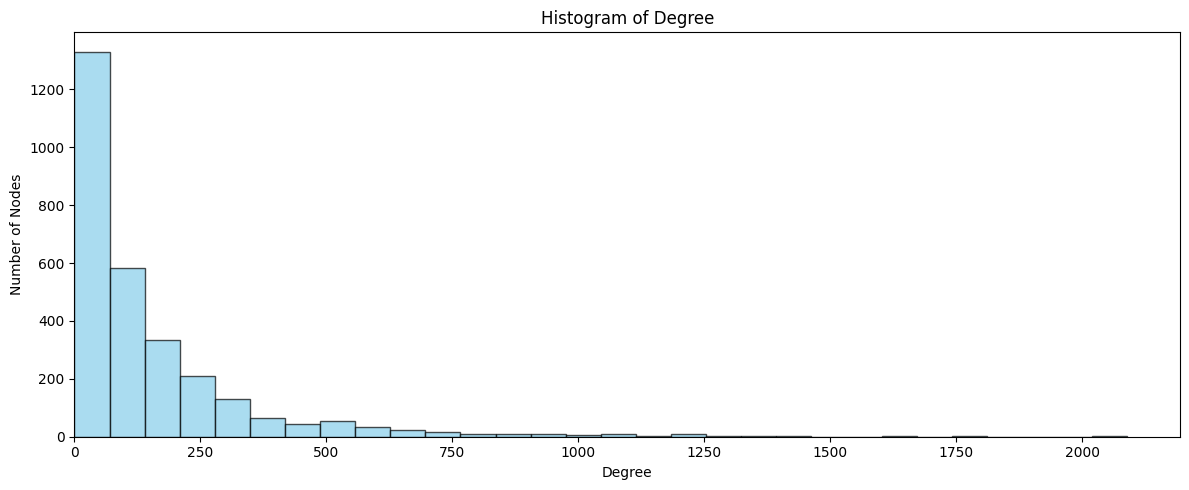

In [4]:
# create histogram to visualize

degrees = np.array([G.degree(node) for node in G.nodes()])

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(degrees, bins=30, color='skyblue', edgecolor='black', alpha=0.7, 
        label='Unweighted Degree')

ax.set_xlabel("Degree")
ax.set_ylabel("Number of Nodes")
ax.set_title("Histogram of Degree")

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


#### Discussion of the degree findings

With the above average degree value and weighted degree, in relation to the number of total edges within the network, and the fact that the density is 0.05, we can conclude that our network is relatively sparse, with very few edges. However, the average number of edges is quite high, so further investigation into the distribution of these edges, and into the "strength" of these edges is conducted below.

### Scale-Free Network Investigation

Below is an investigation into whether the network has scale-free attributes, specifically focusing on comparing it to a lognormal distribution of degrees. Here we focus on finding the minimum degree number where the network attributes could be captured under scale-free attributes, and also a likelihood ratio of whether power-law is plausible or if lognormal fits better.

In [5]:
#calculating the power-law, to observe whether the network is scale-free or not.
pl_degree = list(dict(G.degree()).values())

fit = powerlaw.Fit(pl_degree, discrete=True)
gamma = fit.power_law.alpha
xmin = fit.power_law.xmin


#gamma will show us info sbout the degree distribution
print("Power-law exponent γ:", gamma)

#xmin will show us from what degree value the power law is a best fit
print("xmin:", xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law exponent γ: 3.5749514348246505
xmin: 475.0


#### Discussion of Power-Law attributes

Similarly captured by our histogram, the Power-Law Exponent value of 3.575 shows an incredibly steep degree distribution.

However, with an xmin value of 475, which means that the power-law is valid for nodes with a degree ≥ 475, this means that the tail where our high-degree nodes are located may be better captured by the power-law

## 3. Small World Attributes - Average Clustering and Path Length

With the degree distribution discussed, we will now focus on the structuring on the edges between nodes, and how the network is clustered. Through utilising the largest connected component, named H, we want to foucs on whether the network has any small-world properties, through comparing the average clustering coefficient and average shortest path length with randomly generated networks.

In [6]:
#diameter of the network
#getting the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)
diameter= nx.diameter(H)

#printing the results
print(f"The diameter of the network is {round(diameter, 2)}.")

The diameter of the network is 5.


In [7]:
#average clustering coefficient 
clustering_coef = nx.average_clustering(H)

#average shortest path
shortest_path = nx.average_shortest_path_length(H)

#printing results
print(f"The DayZero network have the average clustering coefficient of {clustering_coef}")
print(f"The DayZero network have the average shortest path of {shortest_path}")

The DayZero network have the average clustering coefficient of 0.7667190654760123
The DayZero network have the average shortest path of 2.050784787091188


In [8]:
#randomly creating comparable graphs
n = G.number_of_nodes()
m = G.number_of_edges()

Crand_list = []
Lrand_list = []

nrand = 10 

for _ in range(nrand):
    p = (2*m) / (n*(n-1))
    R = nx.gnp_random_graph(n, p)
    
    if not nx.is_connected(R):
        continue
    
    Crand_list.append(nx.average_clustering(R))
    Lrand_list.append(nx.average_shortest_path_length(R))

#calculating the aveage values of the randomly generated networks

Crand = np.mean(Crand_list)
Lrand = np.mean(Lrand_list)

#computing the small world coefficent 
sigma = (clustering_coef / Crand) / (shortest_path / Lrand)

print("Small-world coefficient σ:", sigma)
print("Is small-world?", sigma > 1)
print(f"Network Average Clustering Coefficient={clustering_coef}, Network's Average Longest Shortest Path={shortest_path}, Crand={Crand}, Lrand={Lrand}")


Small-world coefficient σ: 13.87162179663344
Is small-world? True
Network Average Clustering Coefficient=0.7667190654760123, Network's Average Longest Shortest Path=2.050784787091188, Crand=0.05249795830454905, Lrand=1.94784088554486


### Discussion of Small-World Attributes

With the attributes of "Average Clustering Coefficient", and the "Average Shortest Path Length", and comparing them to the same coefficient's of a randomly generated network, we can observe whether our network has small-world attributes. This is normally denoted by a high average clustering coefficent, where we have 0.766, and a small average shortest path length, where we have 2.050. This, therefore is the case with our network, and this is reinforced with our high sigma value, 13.876 which is much larger than 1, which means our network can qualify to be a small-world network.

## 4. Goal Investigation - Degree Values and Centrality Measures

Moving onto this part, we now investigate the nodes in terms of the goals that they represent, and what we can understand from the high and low degree values.

Similarly, we investigate the different centrality measures and observe who the key players in terms of influentiality and/or acting as bridges between the different nodes.

### Degree Values

In [9]:
data_degree = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    score = attrs.get("degree")
    if title is not None and score is not None:
        data_degree.append((title, score))


# Sort by highest degree
sorted_goals_highest_degree = sorted(data_degree, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest Degrees:")
for title, score in sorted_goals_highest_degree:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Highest Degrees:
See the Northern Lights                  2089.0000
Get a tattoo                             1767.0000
Visit the Grand Canyon                   1756.0000
Donate blood                             1662.0000
Get a massage                            1429.0000
Leave an inspirational note inside a book for someone to find 1419.0000
Visit Italy                              1372.0000
Find out my blood type                   1350.0000
Watch a meteor shower                    1319.0000
Learn Spanish                            1266.0000


In [10]:
#sort by lowest degree

sorted_goals_lowest_degree = sorted(data_degree, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Lowest Degrees:")
for title, score in sorted_goals_lowest_degree:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Lowest Degrees:
Learn to play the viola                  0.0000
Go to Thorpe Park                        0.0000
Read The Alchemist                       0.0000
Visit Gatlinburg                         0.0000
Witness the Northern Lights in the Shetland Islands 0.0000
Read The God Delusion                    0.0000
Learn to play squash                     0.0000
Read The Little Prince                   0.0000
Read all of Chuck Palahniuk's books      0.0000
Watch Gone With the Wind                 0.0000


In [11]:
weighted_degree = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    score = attrs.get("weighted degree")
    if title is not None and score is not None:
        weighted_degree.append((title, score))

# Sort by highest weighted degree
sorted_weighted_degree = sorted(weighted_degree, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest Weighted Degree:")
for title, score in sorted_weighted_degree:
    print(f"{title:<40} {score:.4f}")


Top 10 Nodes with the Highest Weighted Degree:
Donate blood                             14836.0000
See the Northern Lights                  14593.0000
Get a tattoo                             13804.0000
Visit the Grand Canyon                   12226.0000
Leave an inspirational note inside a book for someone to find 11512.0000
Get a massage                            9469.0000
Find out my blood type                   9373.0000
No fast food for a month                 8506.0000
Make a new friend                        7991.0000
Make a birthday cake for someone         7939.0000


In [12]:
#sort by lowest weighted degree

sorted_low_weighted_degree = sorted(weighted_degree, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Highest Lowest Degree:")
for title, score in sorted_low_weighted_degree:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Highest Lowest Degree:
Learn to play the viola                  0.0000
Go to Thorpe Park                        0.0000
Read The Alchemist                       0.0000
Visit Gatlinburg                         0.0000
Witness the Northern Lights in the Shetland Islands 0.0000
Read The God Delusion                    0.0000
Learn to play squash                     0.0000
Read The Little Prince                   0.0000
Read all of Chuck Palahniuk's books      0.0000
Watch Gone With the Wind                 0.0000


#### Discussion of the Highest and Lowest Degree Goals:
Within our case study, there is significant overlap between unweighted and weighted degree for the highest and lowest degree goals. 

From the two calculations of degree, we can observe a huge overlap in goals, in particular the top six goals with the highest degree. The conclusion we can draw from this is that these goals not only occur on the most lists, but also have a high frequency to co-occur with the same goals. The goals themselves are very universal in terms of scope, with travel destinations and activities that focus on the grand scale of the world "Grand Canyon" and "Northern Lights", and more "altruistic" goals such as "Donate Blood" and "Make a new friend".

For our lowest degree nodes, these are our isolated nodes that have no degree. Due to them being isolated nodes, there is no difference when adjusting for weights. The goals themselves are more focused on skill improvement, and more specific forms of media consumption,"Watch Gone With the Wind" and travel destinations "Go to Thorpe Park" and "Visit Gatlinburg".

### Centrality

#### Degree centrality

In [13]:
#degree centrality

deg_centrality = nx.degree_centrality(G)

#adding degree centrality as an attribute

nx.set_node_attributes(G, deg_centrality, "degree centrality")

#setting data up 

data_degree = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    score = attrs.get("degree centrality")
    if title is not None and score is not None:
        data_degree.append((title, score))

# Sort by degree centrality
sorted_goals_centrality = sorted(data_degree, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest Degree Centrality:")
for title, score in sorted_goals_centrality:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Highest Degree Centrality:
See the Northern Lights                  0.7231
Get a tattoo                             0.6116
Visit the Grand Canyon                   0.6078
Donate blood                             0.5753
Get a massage                            0.4946
Leave an inspirational note inside a book for someone to find 0.4912
Visit Italy                              0.4749
Find out my blood type                   0.4673
Watch a meteor shower                    0.4566
Learn Spanish                            0.4382


In [14]:
#lowest centrality, getting values above 0.0000
filtered_data = [item for item in data_degree if item[1] >= 0.0001]

sorted_goals_centrality_low=sorted(filtered_data, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Lowest Degree Centrality:")
for title, score in sorted_goals_centrality_low:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Lowest Degree Centrality:
Visit Mackinaw Island                    0.0003
Visit Bristol                            0.0003
Visit Holden Arboretum                   0.0003
Visit Walden Pond                        0.0003
Read the Doctrine and Covenants          0.0003
Walk the Kinzua Bridge                   0.0003
Visit Little Tokyo                       0.0003
Meet Hayley Williams                     0.0003
Visit the Bronx Museum of the Arts       0.0003
Meet Andrew McMahon                      0.0003


#### Betweenness Centrality

In [15]:
between_centrality =nx.betweenness_centrality(G)

#adding betweenness centrality as an attribute
nx.set_node_attributes(G, between_centrality, "between centrality")

data_betweenness = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    score = attrs.get("between centrality")
    if title is not None and score is not None:
        data_betweenness.append((title, score))

# Sort by betweenness centrality
sorted_goals_between_centrality = sorted(data_betweenness, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest Betweenness Centrality:")
for title, score in sorted_goals_between_centrality:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Highest Betweenness Centrality:
See the Northern Lights                  0.0675
Get a tattoo                             0.0431
Donate blood                             0.0381
Visit the Grand Canyon                   0.0330
Leave an inspirational note inside a book for someone to find 0.0216
Get a massage                            0.0209
Learn Spanish                            0.0167
Find out my blood type                   0.0154
Go skydiving                             0.0152
Visit Italy                              0.0137


In [16]:
#lowest centrality scores, again looking at values above 0.0000
filtered_data_between = [item for item in data_betweenness if item[1] >= 0.0001]

sorted_goals_between_centrality_low=sorted(filtered_data_between, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Lowest Betweenness Centrality:")
for title, score in sorted_goals_between_centrality_low:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Lowest Betweenness Centrality:
Visit Washington                         0.0001
Visit Portugal                           0.0001
Visit Kiyomizu-dera                      0.0001
Visit the Waitomo Glowworm Caves         0.0001
Go hot-air ballooning at Château-d'Oex   0.0001
Make a Christmas cake                    0.0001
Visit Wales                              0.0001
Visit Craters of the Moon National Monument 0.0001
Visit Munich                             0.0001
Photograph an endangered species         0.0001


#### Eigenvector Centrality

In [17]:
#getting the eigenvector centrality

eigenvector_centrality = nx.eigenvector_centrality(G)

#adding eigenvector centrality as an attribute
nx.set_node_attributes(G, eigenvector_centrality, "eigenvector centrality")

data_eigenvector = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    score = attrs.get("eigenvector centrality")
    if title is not None and score is not None:
        data_eigenvector.append((title, score))

# Sort by highest eigenvector centrality
sorted_goals_eigenvector_centrality = sorted(data_eigenvector, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest Eigenvector Centrality:")
for title, score in sorted_goals_eigenvector_centrality:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Highest Eigenvector Centrality:
See the Northern Lights                  0.0917
Visit the Grand Canyon                   0.0866
Get a tattoo                             0.0844
Donate blood                             0.0824
Get a massage                            0.0768
Visit Italy                              0.0767
Leave an inspirational note inside a book for someone to find 0.0752
Find out my blood type                   0.0749
Watch a meteor shower                    0.0749
Learn Spanish                            0.0734


In [18]:
#now again, sorting by the lowest eigenvector centrality, looking at values above 0.0001
filtered_data_eigenvector = [item for item in data_eigenvector if item[1] >= 0.0001]

sorted_goals_eigenvector_centrality_low=sorted(filtered_data_eigenvector, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Lowest Eigenvector Centrality:")
for title, score in sorted_goals_eigenvector_centrality_low:
    print(f"{title:<40} {score:.4f}")

Top 10 Nodes with the Lowest Eigenvector Centrality:
Read Animal Farm                         0.0001
Visit Miami Seaquarium                   0.0001
Hike the Long Trail                      0.0001
Participate in the Mongol Rally          0.0001
Explore Chittorgarh Fort                 0.0001
Visit Socotra Island                     0.0001
Meet Andrew McMahon                      0.0001
Visit Dolfinarium                        0.0001
Visit Cathedral Caverns State Park       0.0001
Learn Bahasa Indonesia                   0.0001


#### Discussion of Centrality Measures

Outside of the occurrence of certain goals measuring a baseline degree importance, in regards to other goals, we are also interested in different centrality measures within our network. This is to gain an understanding of what the most influential goals are within our network, and if there are certain goals that act as bridges, connecting numerous different goals. From our understanding, all three measures, “Degree Centrality”, “Betweenness Centrality” and “Eigenvector Centrality” produce nearly the same top ten highest goals, aside from the “Go Skydiving” goal in our “Betweenness Centrality” list.

These goals encapsulate a wide variety of themes, such as travel, altruism, and improvement of skills, which aligns with previous literature (Periyakoil et. al, 2018), and can be considered quite universal and widely encapsulating goals, in comparison to the more niche goals that exist on the opposite end of the centrality measures.

On the opposite end of these centrality measures, the lowest scoring in terms of centrality measures, both those that score 0 and above to 0.0001, are relative specific and obscure goals such as “Go hot-air ballooning at Château-d'Oex”, and “Visit Cathedral Caverns State Park”. These goals are much more unique to the individual, and have little contribution to the “main” goals that humans want to complete. This follows a similar dynamic to that of the high and low degree nodes, where more "universal" goals have higher centrality and more specified goals are located on the lower end of the centrality distribution.

## 5. User Interaction with Goals - List Appearance and Completedness


In [19]:
#utilising the have_done and want_to_do attributes of the network

user_frequency = {}

for node, data in G.nodes(data=True):
    done = data.get("have_done", 0)
    want = data.get("wants_to_do", 0)
    
    # Ensure the values are valid integers
    if not isinstance(done, int):
        done = 0
    if not isinstance(want, int):
        want = 0
    
    user_frequency[node] = done + want

sorted_freq = sorted(user_frequency.items(), key=lambda x: x[1], reverse=True)

In [20]:
#top ten "uncommon" or infrequent goals
sorted_freq_low = sorted(user_frequency.items(), key=lambda x: x[1])

for node, freq in sorted_freq_low[:10]:
    title = G.nodes[node].get("title", "No title")
    print(f"{title} — {freq} users have this goal on their list")

Visit Taghazout — 0 users have this goal on their list
Raft the Rogue River in Southern Oregon — 0 users have this goal on their list
Visit Buenos Aires Zoo — 0 users have this goal on their list
Visit DeGray Lake Resort State Park — 1 users have this goal on their list
Swim in Clevedon Marine Lake — 1 users have this goal on their list
Visit Lanzarote — 1 users have this goal on their list
Visit the Charles Rennie MacKintosh house in Glasgow — 1 users have this goal on their list
Visit Johannesburg — 1 users have this goal on their list
Do a yoga retreat in Essaouira — 1 users have this goal on their list
Visit Necker Island — 1 users have this goal on their list


In [21]:
#what goals have actually been completed by the entire population of DayZero
completion_counts = {}

for node, data in G.nodes(data=True):
    count = data.get("have_done", None)

    if isinstance(count, int) and count >= 0:
        completion_counts[node] = count

top_completed = sorted(completion_counts.items(), key=lambda x: x[1], reverse=True)

for node, count in top_completed[:10]:
    title = G.nodes[node].get("title", "No title")
    print(f"{title} — completed by {count} users")

Donate blood — completed by 3361 users
Make a new friend — completed by 2987 users
Get a tattoo — completed by 2856 users
Find out my blood type — completed by 2704 users
Get a massage — completed by 2622 users
Go ice skating — completed by 2395 users
Graduate — completed by 2344 users
Make a birthday cake for someone — completed by 2086 users
Bake cupcakes — completed by 1996 users
Take a Yoga class — completed by 1605 users


In [22]:
#distribution of users from only OUR network instead of the entire site

data_included_users = []
for node, attrs in G.nodes(data=True):
    title = attrs.get("title")
    user_number = attrs.get("included_by_our_users")
    if title is not None and user_number is not None:
        data_included_users.append((title, user_number))

# Sort by highest user inclusion rate
sorted_goals_included_users = sorted(data_included_users, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes with the Highest User Inclusion Number:")
for title, count in sorted_goals_included_users:
    print(f"{title} — included by {count} users")

Top 10 Nodes with the Highest User Inclusion Number:
Donate blood — included by 1672 users
Get a tattoo — included by 1458 users
Leave an inspirational note inside a book for someone to find — included by 1183 users
See the Northern Lights — included by 926 users
Find out my blood type — included by 868 users
Get a massage — included by 811 users
Make a new friend — included by 786 users
No fast food for a month — included by 786 users
Go skydiving — included by 685 users
Make a birthday cake for someone — included by 640 users


In [23]:
# Sort by lowest user inclusion rate
sorted_goals_low_included_users = sorted(data_included_users, key=lambda x: x[1])[:10]

print("Top 10 Nodes with the Lowest User Inclusion Number:")
for title, count in sorted_goals_low_included_users:
    print(f"{title} — included by {count} users")

Top 10 Nodes with the Lowest User Inclusion Number:
Visit Angel Island — included by 1 users
Watch an Elvis Presley movie — included by 1 users
Learn to play the viola — included by 1 users
Visit Tintagel Castle — included by 1 users
Bike RAGBRAI — included by 1 users
Learn to wolf whistle — included by 1 users
Visit the Blue Lagoon — included by 1 users
Travel the Silk Road — included by 1 users
Attend the Jaipur Literary Festival — included by 1 users
Explore the Suomenlinna Maritime Fortress — included by 1 users


#### Discussion of Users and Goals

With this in mind, we observe the goals that are most “popular” in terms of the amount of users that have these goals on their list. Specifically, the amount of overlap from the highest centrality goals and the amount of users. For those goals with the highest number of users, we can observe a significant overlap, both in regards to our lists of high degree and centrality. This could allude to the aforementioned “universality” of these goals, but also perhaps in terms of ease of completion. On the opposite ends of the spectrum, with goals that occur on zero lists, or on a single list, these are very-specified travel goals, or travel-activity goals. This reinforces our findings from the centrality scores, that these are more tailored to the individual, rather than the “general” population of the site

## 6. DataFrame of all Attributes

In [25]:
#displaying the findings in a dataframe
node_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
node_df.index.name = 'node'  # optional: name the index
node_df.head()

,title,description,wants_to_do,have_done,comments,tags,included_by_our_users,category,country,city,other_map_location,degree,weighted degree,degree centrality,between centrality,eigenvector centrality
node,,,,,,,,,,,,,,,,
dQggEQQH,Make ice cream from scratch,Ice cream or ice-cream is a frozen dessert usu...,3010,973,[We made ice cream using a friend’s ice cream ...,"[Food, Recipe, Chocolate, Fruit, Cooking, Food...",438,Food,None,None,None,898,5000,0.310834,0.005706,0.059015
nnEnjr7O,Leave an inspirational note inside a book for ...,Imagine the joy of discovering a heartfelt mes...,9856,966,"[Can do it at Church, local library, a book yo...","[Creativity, Mindfulness, Community, Literatur...",1183,Acts of kindness/altruism,None,None,None,1419,11512,0.491173,0.021580,0.075170
nusyxQLs,Fly a kite,A kite is a tethered heavier-than-air or light...,3030,1199,[The winds were crazy yesterday but today they...,"[Outdoor Activities, Relaxation, Beach, Family...",463,Experiences,None,None,None,996,5643,0.344756,0.005641,0.064543
MDTcjx4X,Go skydiving,"Parachuting, including also skydiving, is a me...",5318,618,"[There is no way I will ever this goal 😞, Plan...","[Outdoor Activities, Scenic Views, Personal Gr...",685,Experiences,None,None,None,1248,7092,0.431983,0.015235,0.071992
GM7VTx2U,Visit the Library of Congress,The Library of Congress is the research librar...,69,66,[Took the tour and it was excellent!],"[Travel, Culture, Tourism, Architecture, Landm...",11,Places of interest,United States,Washington D.C.,Library of Congress,178,231,0.061613,0.000504,0.019189
